In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from library.model import density_last
from library.model import proximity_last
from library.model import martingale
from library.model import p_value
from library.model import KNNAnomalyDetector

%matplotlib inline

## 方法总论


在这个notebook中，我们在鞅（martingle）的框架下应用Vovk等人的在线可交换性检验（online exchangeability test）来检验一个时间序列中的异常。具体来讲，我们使用如下几步来进行异常侦测：

1. 输入数据流中的一个数据点被观测到
2. 基于一个“陌生测度（strangeness measure）”进行差异计算
3. 基于H0：无异常 的原始假设进行一个假设检验，获得p值
4. 构造一个随机power martingale（鞅）
5. 使用鞅值进行假设检验

在这个notebook中，我们解释了以上检验的实施流程。

## 陌生测度

我们希望陌生测度具备如下性质：
1. 能处理多维度时间序列
2. 能处理无标注数据
3. 简单灵活

我们决定实施两种基于KNN算法的测度：
1. 基于逼近度的“邻间最大距离”
2. 基于密度的“邻间相对密度”

邻间最大距离测度非常直观，给定一个数据点及其K个近邻，我们计算到最远近邻点的某个距离。邻间相对密度稍微复杂一点。给定K个近邻，我们将密度定义为该点及其近邻的距离和的倒数。具体来说就是用点间密度除以所有K个近邻的密度和。


## P-Value

计算如下:

$$p = \frac{ count(i:a_{i} > a_{n}) + \theta*count(i:a_{i} = a_{n}) }{n}$$

其中 $a_{i}$ 是第 $i-th$ 个观测的陌生测度，而 $\theta$ 是 $[0, 1]$ 间随机选的一个参数。

## 随机 Power Martingale

计算如下:

$$M_{n} = \epsilon p_{n}^{(\epsilon - 1)} M_{n - 1}$$

其中 $\epsilon$ 是 $[0, 1]$之间的浮点数。

## 实施细节


我们设计一个叫做KNNAnomalyDetector的类，其参数如下：

     - 阈值 -- 浮点数，可选，缺省值2.0。如果超过阈值，则报告异常
     - epsilon -- 浮点数，可选，缺省值 0.92。这是一个0.0到1.0之间的浮点数，用于鞅的计算
     - 近邻数 -- 整数，可选，缺省值3。近邻的数量
     - 计量单位 -- 字符，可选，缺省值'euclidean'。这是用于计算每个点与近邻的距离的计量方法
     - 方法 -- 字符，'density'或者'proximity'，缺省值'density'。计算陌生函数的方法。当标注为'density'时，陌生测度使用邻间相对密度；当标注为'proximity'时，陌生测度使用邻间最大距离
     - 异常 -- 字符，'level'或'change'，缺省值'level'。使用阈值的方法。当标注为'level'时，鞅值直接与阈值比较；当标注为'change'时，鞅的变化与阈值进行比较


## 打造直观感觉


下面我们来看两个有异常的数据集，选定陌生测度及其对应的方法后分析其整体表现。

### 样本一：

该数据集由一个100个服从高斯分布的数据点的聚集与由10个点从该数据聚合处横穿而过的直线两部分构成。其中直线部分表示数据的缓慢变化。

In [2]:
def gen_data1(mult = 1.0):
    C = np.array([[1., 3.7], [1.9, 2.7]])
    d1 = np.dot(np.random.randn(90, 2), C) + np.array([20, 20])
    d2 = np.concatenate((
            np.dot(np.random.randn(2, 2), C) + np.array([20, 20]),
            np.column_stack((np.linspace(20., 30.*mult, num = 10), np.linspace(20., 10.*mult, num = 10)))
    ))
    return d1, d2

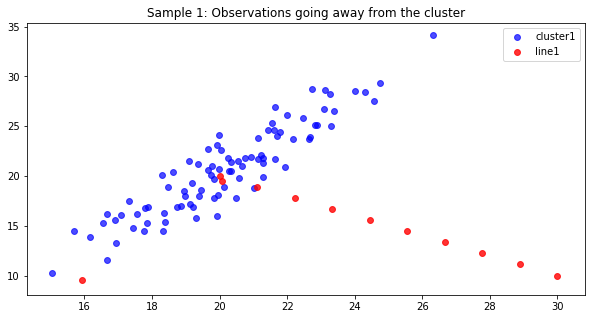

In [3]:
cluster1, line1 = gen_data1()

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(cluster1[:, 0], cluster1[:, 1], c='blue', alpha=0.7, label='cluster1', s=35)
ax.scatter(line1[:, 0], line1[:, 1], c='red', alpha=0.8, label='line1', marker='o',s=35)
ax.set_title('Sample 1: Observations going away from the cluster')
ax.legend(loc='best')
a = ax.axis('tight')

### 样本 2: 
该数据集由一个有30个服从高斯分布的数据点集合和另外一个该集合之外的20个数据点构成的集合构成。这20个数据点代表平均数值的突然变化。

In [4]:
def gen_data2(mult = 1.0):
    C = np.array([[1.5, 3.7], [2.5, 2.7]])
    d1 = np.dot(np.random.randn(30, 2), C) + np.array([20, 20])
    d2 = np.concatenate((
            np.dot(np.random.randn(2, 2), C) + np.array([20, 20]),
            np.dot(np.random.randn(20, 2), np.array([[.7, 0.2], [.5, .8]])) + np.array([35*mult, 5*mult])
        ))
    return d1, d2

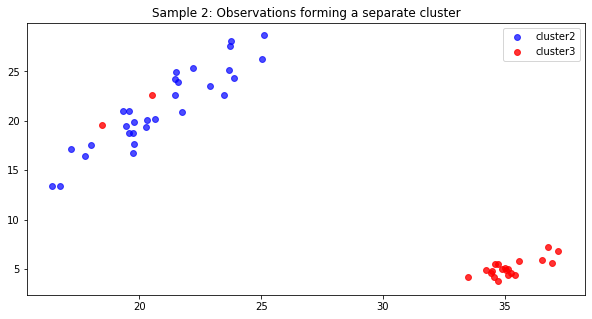

In [5]:
cluster2, cluster3 = gen_data2()

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(cluster2[:, 0], cluster2[:, 1], c='blue', alpha=0.7, s=35, label='cluster2')
ax.scatter(cluster3[:, 0], cluster3[:, 1], c='red', marker='o', alpha=0.8, s=35, label='cluster3')
ax.set_title('Sample 2: Observations forming a separate cluster')
ax.legend(loc='best')
a = ax.axis('tight')

##  陌生测度

我们通过观测陌生测度在上面的数据集中如何变化开始打造直觉感受。为了模拟“在线”，我们依照数据点生成的顺序来观测它们，并对观测到的最后一个数据点计算“邻间相对密度”和“邻间最大距离”两种陌生测度。

## 不同计量单位下的陌生测度

我们的陌生测度函数可以应用以下几种计量距离：  

- 'euclidean' 欧式距离:  $sqrt(sum((x - y)^2))$
- 'manhattan' 曼哈顿距离:  $sum(|x - y|)$
- 'chebyshev' 切比雪夫距离   $max(|x - y|)$

我们下面来看看不同的计量距离如何影响陌生测度的结果。

In [6]:
metrics = ['euclidean', 'manhattan', 'chebyshev']

### 样本 1: 观测点缓慢的偏离聚集区域

euclidean

manhattan

chebyshev



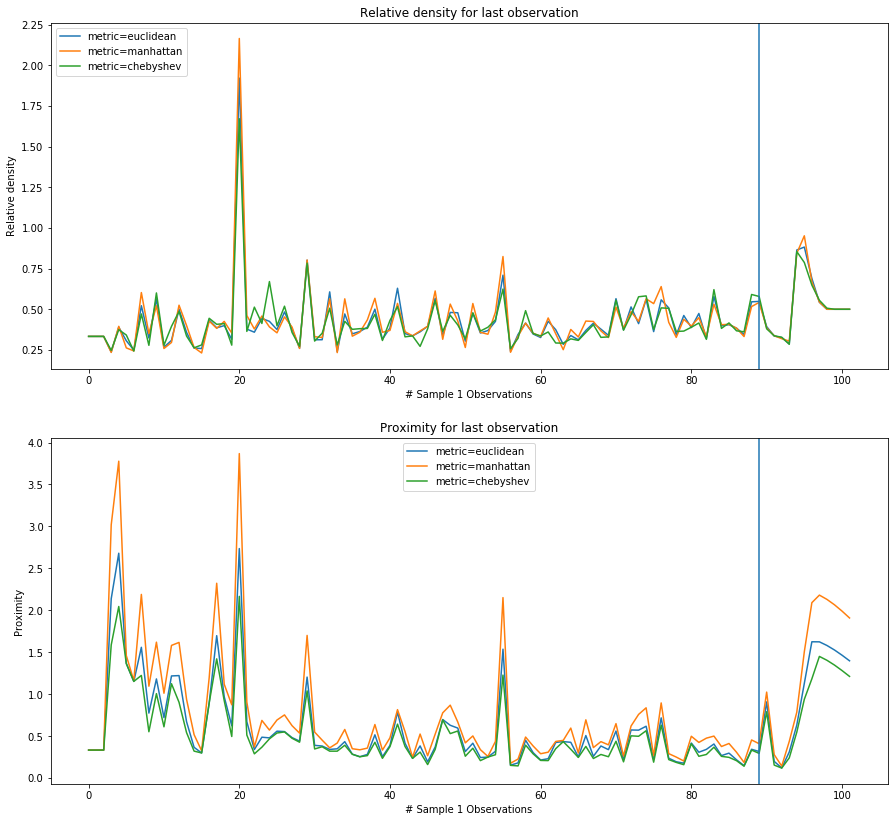

In [7]:
fig = plt.figure(figsize=(15, 14))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

for metric in metrics:
    print(metric)
    observations = []
    D = []
    P = []
    for x in np.concatenate((cluster1, line1)):
        observations.append(x)
        X = StandardScaler().fit_transform(np.array(observations))
        D.append(density_last(X, n_neighbors = 3, metric = metric))
        P.append(proximity_last(X, n_neighbors = 3, metric = metric))
    ax1.plot(D, label = 'metric=' + metric)
    ax2.plot(P, label = 'metric=' + metric)
    print('===============', '\n')
    
ax1.axvline(x = cluster1.shape[0] - 1)
ax1.set_xlabel('# Sample 1 Observations')
ax1.set_ylabel('Relative density')
ax1.set_title('Relative density for last observation')
ax1.legend(loc='best')

ax2.axvline(x = cluster1.shape[0] - 1)
ax2.set_xlabel('# Sample 1 Observations')
ax2.set_ylabel('Proximity')
ax2.set_title('Proximity for last observation')
ax2.legend(loc='best')


首先，在聚集区域形成的初期，陌生测度有一个明显的突增。虽然这个时候对于其对异常侦测模型性能的影响还不清楚，但是我们需要留意这一点。


在两个数据集中，陌生测度的结果随着数据背后生成过程的改变而变化。数据生成过程发生变化的点已经用蓝色垂直线标出。可以看出，“邻间最大距离”相对更敏感一些。


当采用不同的计量距离的时候，陌生测度的结果有明显的不同。因此我们需要用真实的多维度数据来验证计量距离对模型侦测效果的影响。

### 样本 2: 观测点形成不同的聚集区或者有突变的情况

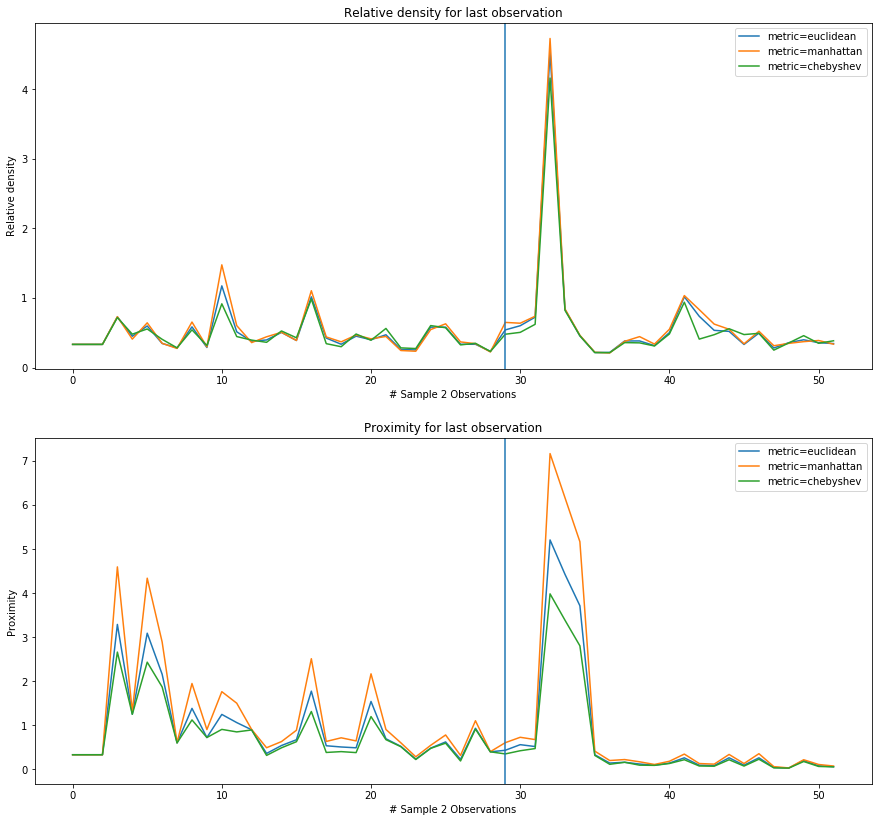

In [8]:
fig = plt.figure(figsize=(15, 14))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

for metric in metrics:
    observations = []
    D = []
    P = []
    for x in np.concatenate((cluster2, cluster3)):
        observations.append(x)
        X = StandardScaler().fit_transform(np.array(observations))
        D.append(density_last(X, n_neighbors = 3, metric = metric))
        P.append(proximity_last(X, n_neighbors = 3, metric = metric))
    ax1.plot(D, label = 'metric=' + metric)
    ax2.plot(P, label = 'metric=' + metric)
    
ax1.axvline(x = cluster2.shape[0] - 1)
ax1.set_xlabel('# Sample 2 Observations')
ax1.set_ylabel('Relative density')
ax1.set_title('Relative density for last observation')
ax1.legend(loc='best')

ax2.axvline(x = cluster2.shape[0] - 1)
ax2.set_xlabel('# Sample 2 Observations')
ax2.set_ylabel('Proximity')
ax2.set_title('Proximity for last observation')
ax2.legend(loc='best')


两种方法的表现都不错，都很清楚地对明显‘异常’的点生成了较大的陌生测度结果。

## 不同近邻数对陌生测度的影响

接下来，我们验证近邻的数量如何影响陌生测度的结果。

In [9]:
neighborhoods = [1, 2, 3, 4, 5, 6]

### 样本 1: 观测点缓慢的偏离聚集区域

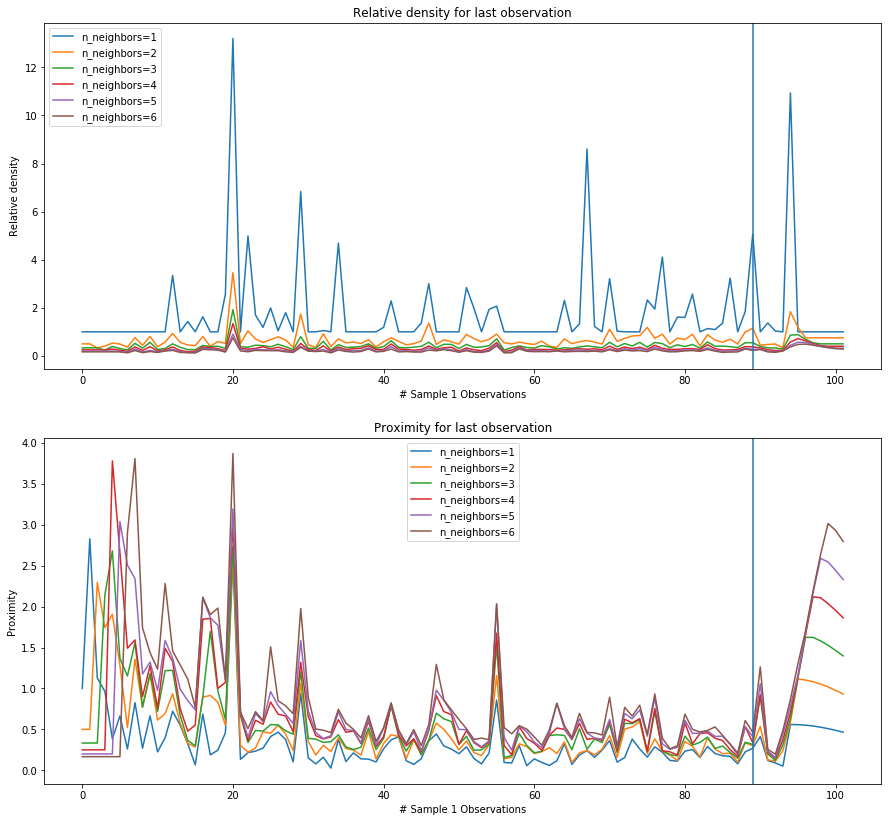

In [10]:
fig = plt.figure(figsize=(15, 14))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

for n_neighbors in neighborhoods:
    observations = []
    D = []
    P = []
    for x in np.concatenate((cluster1, line1)):
        observations.append(x)
        X = StandardScaler().fit_transform(np.array(observations))
        D.append(density_last(X, n_neighbors = n_neighbors, metric = 'euclidean'))
        P.append(proximity_last(X, n_neighbors = n_neighbors, metric = 'euclidean'))
    ax1.plot(D, label = 'n_neighbors=' + str(n_neighbors))
    ax2.plot(P, label = 'n_neighbors=' + str(n_neighbors))
    
ax1.axvline(x = cluster1.shape[0] - 1)
ax1.set_xlabel('# Sample 1 Observations')
ax1.set_ylabel('Relative density')
ax1.set_title('Relative density for last observation')
ax1.legend(loc='best')

ax2.axvline(x = cluster1.shape[0] - 1)
ax2.set_xlabel('# Sample 1 Observations')
ax2.set_ylabel('Proximity')
ax2.set_title('Proximity for last observation')
ax2.legend(loc='best')


当n_neighbors = 1，“邻间相对距离”无法有效侦测逐渐偏离聚集区的点。看起来应该使用相对更“传统”的近邻数，例如3到5之间的整数。

“邻间最大距离”在这种情况下，无论采用哪种近邻数表现都错。看起来，当使用较大的近邻数时，陌生测度值能在较长时间种保持较大取值。

### 样本 2: 观测点形成不同的聚集区或者有突变的情况

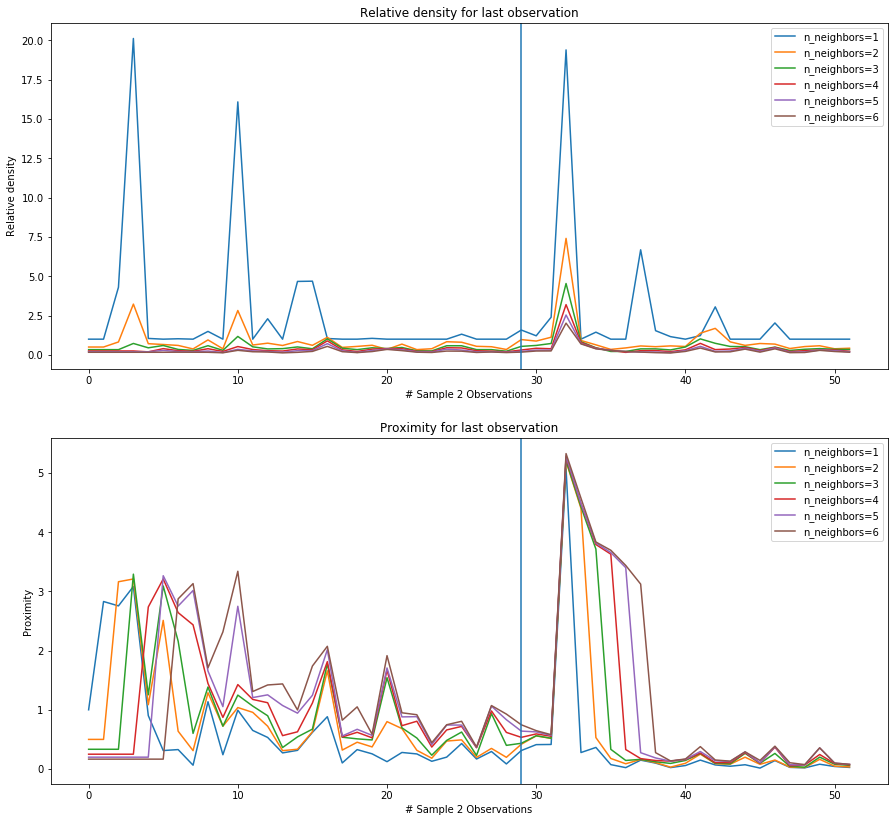

In [11]:
fig = plt.figure(figsize=(15, 14))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

for n_neighbors in neighborhoods:
    observations = []
    D = []
    P = []
    for x in np.concatenate((cluster2, cluster3)):
        observations.append(x)
        X = StandardScaler().fit_transform(np.array(observations))
        D.append(density_last(X, n_neighbors = n_neighbors, metric = 'euclidean'))
        P.append(proximity_last(X, n_neighbors = n_neighbors, metric = 'euclidean'))
    ax1.plot(D, label = 'n_neighbors=' + str(n_neighbors))
    ax2.plot(P, label = 'n_neighbors=' + str(n_neighbors))
    
ax1.axvline(x = cluster2.shape[0] - 1)
ax1.set_xlabel('# Sample 2 Observations')
ax1.set_ylabel('Relative density')
ax1.set_title('Relative density for last observation')
ax1.legend(loc='best')

ax2.axvline(x = cluster2.shape[0] - 1)
ax2.set_xlabel('# Sample 2 Observations')
ax2.set_ylabel('Proximity')
ax2.set_title('Proximity for last observation')
ax2.legend(loc='best')


明显的，分开的两个聚集区数据集非常容易地在两个方法下都被很容易地侦测出来。“邻间相对密度”似乎更稳定，并对初始化不敏感，而“邻间最大距离”由于能在较长时间内产生较大的陌生测度值，因此当我们需要较长时间让鞅变得更置信的时候，这个方法更好。

## 鞅和Epsilon值


初始的鞅值是$M_{0} = 1.0$，随着新的观测值的进入，我们持续更新鞅值为$M_{n} = \epsilon p_{n}^{(\epsilon - 1)} M_{n - 1}$, 其中 $p$ 是p值。

更改epsilon值会改变鞅值随大或者小的p值上升和下降的速率。

我们下面模拟一组p值，这组p值代表输入数据中数值的变动，并观测不同epsilon值下鞅值的变化。

In [12]:
linestyles = ['h', '-', '--', 'o', 'v']
epsilons = np.linspace(0.15, 0.95, num = 9)

Text(0.5, 1.0, 'Martingale change by epsilon value')

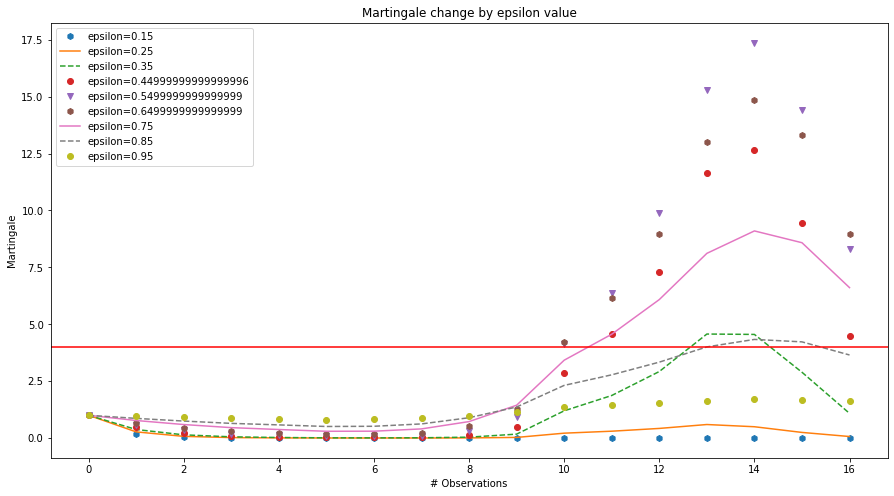

In [13]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1)

for i, epsilon in enumerate(epsilons):
    M = [1.0]
    for p in np.array([0.9, 0.9, 0.9, 0.7, 0.8, 0.3, 0.1, 0.03, 0.02, 0.01, 0.1, 0.1, 0.1, 0.2, 0.4, 0.9]):
        M.append(martingale(M[len(M)-1], p, epsilon))
    ax.plot(M, linestyles[i%len(linestyles)], label = 'epsilon=' + str(epsilon))
ax.axhline(y=4.0, color='r', linestyle='-')
ax.set_xlabel('# Observations')
ax.set_ylabel('Martingale')
ax.legend(loc='best')
ax.set_title('Martingale change by epsilon value')

 
如果数据流在一段时间内没有变化，鞅值会变得非常小。

Text(0.5, 1.0, 'Martingale decreasing with non-strange observations')

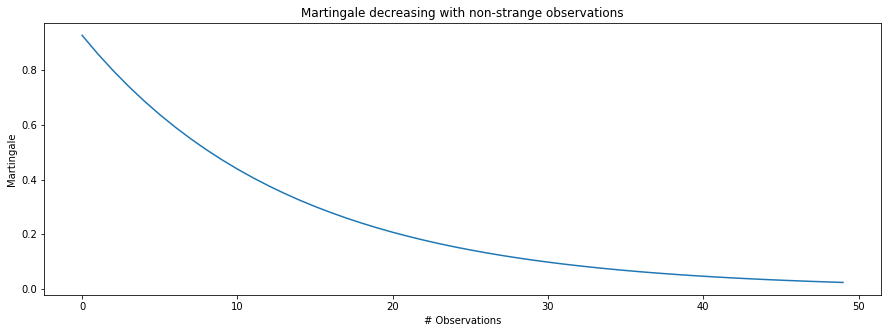

In [14]:
M = []
epsilon = 0.92
m = 1.0
for p in np.repeat(0.9, 50):
    m = martingale(m, p, epsilon)
    M.append(m)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(M)
ax.set_xlabel('# Observations')
ax.set_ylabel('Martingale')
ax.set_title('Martingale decreasing with non-strange observations')


我们需要了解当异常值开始出现的时候，鞅值多快会发生变动。

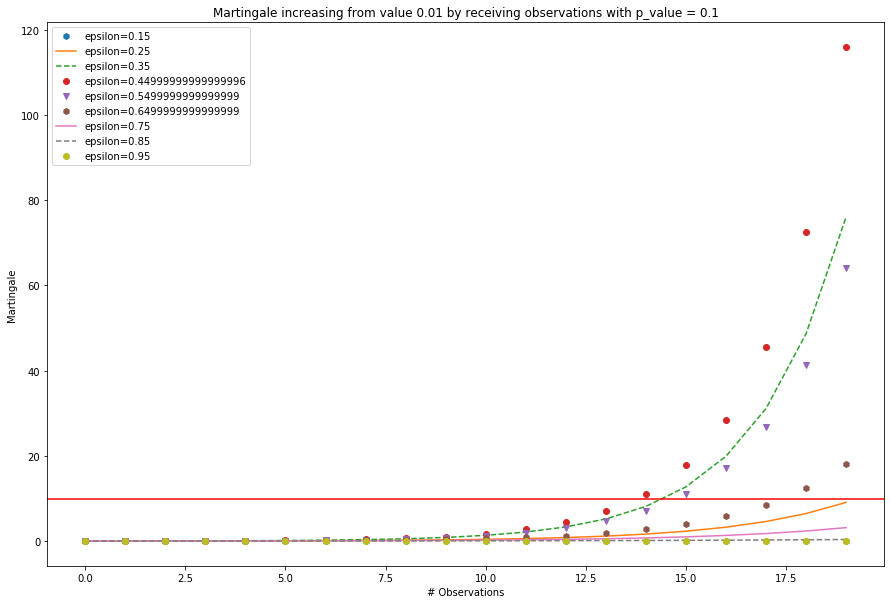

In [15]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)

m_initial = 0.01
p_observed = 0.1

for i, epsilon in enumerate(epsilons):
    M = []
    m = m_initial
    for p in np.repeat(p_observed, 20):
        m = martingale(m, p, epsilon)
        M.append(m)
    ax.plot(M, linestyles[i%len(linestyles)], label = 'epsilon=' + str(epsilon))

ax.axhline(y=10.0, color='r', linestyle='-')
ax.set_xlabel('# Observations')
ax.set_ylabel('Martingale')
ax.set_title(
    'Martingale increasing from value {} by receiving observations with p_value = {}'.format(m_initial, p_observed))
ax.legend(loc='best')    



基于epsilon=0.45的鞅值在第14步的时候突破10.0的阈值。对于近邻相对密度计量距离，因为其相对稳定，因此我们需要考虑较低的阈值。而近邻最大距离更适用于较小的epsilon值是。

In [16]:
def observations_to_breach(m_initial, p_observed, epsilon, threshold):
    m = m_initial
    n_recover = 0
    for p in np.repeat(p_observed, 1000):
        n_recover += 1
        m = martingale(m, p, epsilon)
        if m > threshold:
            break
    return n_recover


在实际工作中，我们在阈值被突破前需要持续获得多个很小的p值，鞅统计量才能有较大的置信度。对于基于KNN的陌生函数这一点不一定适用，因为随着新的近邻的加入，陌生测度值会很快走低。

要更好地理解鞅值在出现异常值的时候如何发生变化，我们需要考察所有的影响因子：

- 初始鞅值
- 观测到的p值
- 突破阈值的时间步数
- 不同的epsilon参数

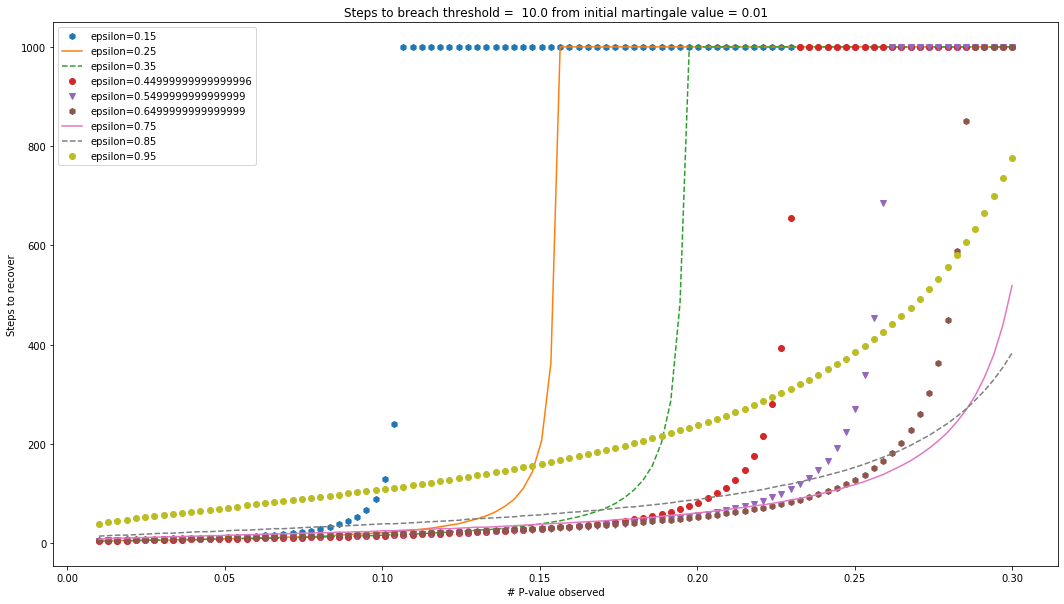

In [17]:
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(1, 1, 1)

threshold = 10.0
m_initial = 0.01

pvalues = np.linspace(0.01, 0.3, num = 100)
for i, epsilon in enumerate(epsilons):
    results = []
    for p_observed in pvalues:
        results.append(observations_to_breach(m_initial, p_observed, epsilon, threshold))
    ax.plot(pvalues, results, linestyles[i%len(linestyles)], label = 'epsilon=' + str(epsilon))
    
ax.set_title('Steps to breach threshold =  {} from initial martingale value = {}'.format(threshold, m_initial))
ax.set_xlabel('# P-value observed')
ax.set_ylabel('Steps to recover')
ax.legend(loc='best')    


在上图种，我们可以看到，对于很稳定的数据流，较小的epsilon参数应该尽量被避免。比如，适用epsilon=0.15作为参数的鞅值需要1000个p值小于0.1的观测才能突破为10的阈值。

##  使用缺省参数
- 3个近邻
- 使用近邻相对密度计量距离
- 欧氏距离
- epsilon = 0.92

In [18]:
def plot_results(data1, data2, r, title):
    fig = plt.figure(figsize=(15, 8))
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.scatter(data1[:, 0], data1[:, 1], c='blue',alpha=0.7, label='data1', s=30)
    ax1.scatter(data2[:, 0], data2[:, 1], c='red', alpha=0.8, label='data2', marker='o',s=30)
    ax1.axis('tight')
    ax1.legend(loc='best')
    ax1.set_title(title + ': Raw Data')

    ax2 = fig.add_subplot(2, 2, 2)
    ax2.plot(r[:, 0], color='magenta',linewidth=1.2)
    ax2.set_title(title + ': Strangeness')

    ax3 = fig.add_subplot(2, 2, 3)
    ax3.plot(r[:, 1], color='green', linewidth=1.2)
    ax3.set_title(title + ': P-value')

    ax3 = fig.add_subplot(2, 2, 4)
    ax3.plot(r[:, 2], color='navy', linewidth=1.2)
    ax3.set_title(title + ': Martingale')

In [19]:
def perform_experiment(model, data1, data2, title):
    for x in data1:
        model.observe(x)
    results = []
    for x in data2:
        results.append(model.observe(x))
    r = np.array(results)
    plot_results(data1, data2, r, title)

### 样本 1: 观测点缓慢的偏离聚集区域

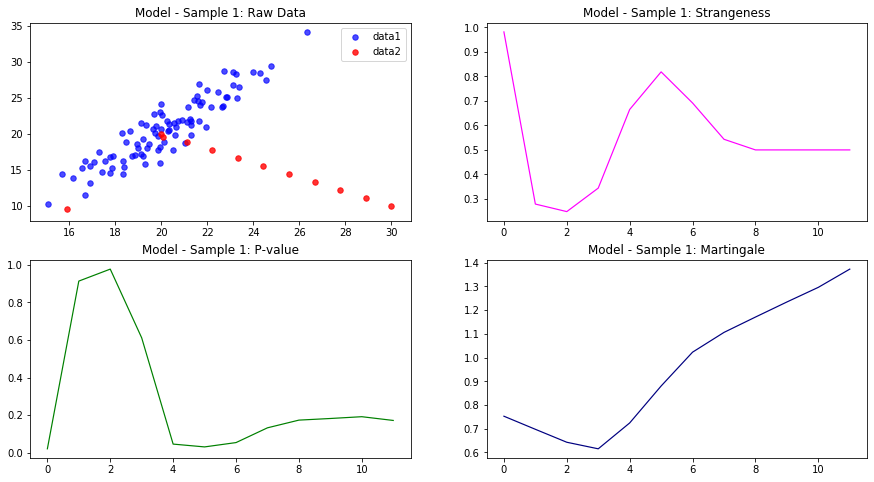

In [20]:
model = KNNAnomalyDetector()
perform_experiment(model, cluster1, line1,'Model - Sample 1')


在这个实验中，我们观测到基于相对密度的陌生测度如何上升的，p值如何下降，以及鞅值如何根据基础数据的变化逐渐变得置信。

### 样本 2: 观测点形成不同的聚集区或者有突变的情况

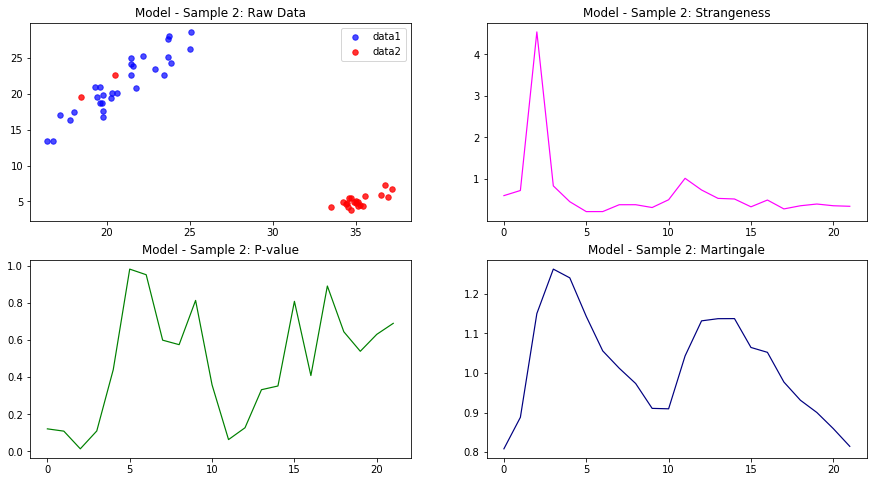

In [21]:
model = KNNAnomalyDetector()
perform_experiment(model, cluster2, cluster3, 'Model - Sample 2')


这个实验凸显了这个模型的一个潜在弱点。如果使用较少的近邻数，我们可能无法侦测数据流中的异常。在这个实验中，当另外一个聚集集合的观测量达到近邻数的时候，相对密度就降低，而鞅值没有足够的时间变得置信。

## 近邻数

我们下面来看看近邻数如何影响模型表现。

### 样本 1: 观测点缓慢的偏离聚集区域

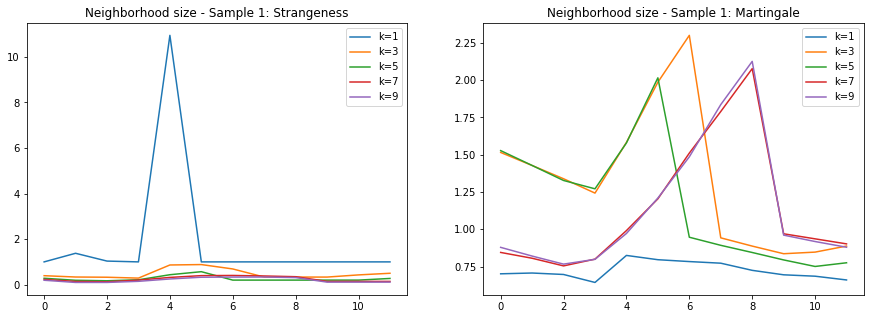

In [22]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('Neighborhood size - Sample 1: Strangeness')

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('Neighborhood size - Sample 1: Martingale')

for n_neighbors in [1, 3, 5, 7, 9]:
    detector = KNNAnomalyDetector(n_neighbors = n_neighbors)
    for x in cluster1:
        detector.observe(x)
    results = []
    for x in line1:
        results.append(detector.observe(x))
    r = np.array(results)
    ax1.plot(r[:, 0], label = 'k=' + str(n_neighbors))
    ax2.plot(r[:, 2], label = 'k=' + str(n_neighbors))
    
ax1.legend()
ax2.legend()

### 样本 2: 观测点形成不同的聚集区或者有突变的情况

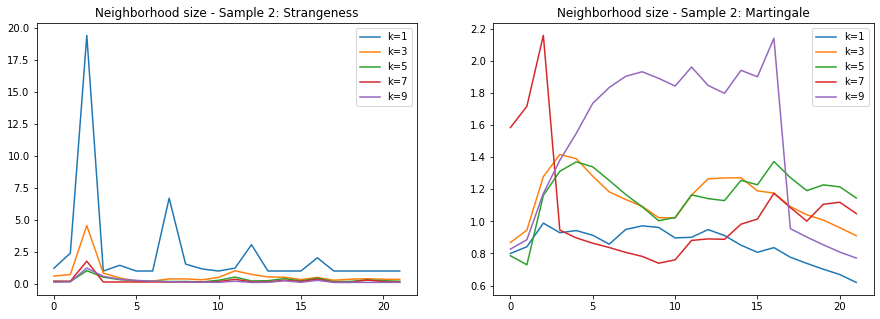

In [23]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('Neighborhood size - Sample 2: Strangeness')

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('Neighborhood size - Sample 2: Martingale')

for n_neighbors in [1, 3, 5, 7, 9]:
    detector = KNNAnomalyDetector(n_neighbors = n_neighbors)
    for x in cluster2:
        detector.observe(x)
    results = []
    for x in cluster3:
        results.append(detector.observe(x))
    r = np.array(results)
    ax1.plot(r[:, 0], label = 'k=' + str(n_neighbors))
    ax2.plot(r[:, 2], label = 'k=' + str(n_neighbors))
    
ax1.legend()
ax2.legend()


结论

- 我们的缺省参数下鞅值的计算对于突变但是不持续的异常不是很敏感
- 更改近邻数对于相对密度的计算及鞅值有较大影响

## 调试不同的epsilon值和近邻值

### 样本 1: 观测点缓慢的偏离聚集区域

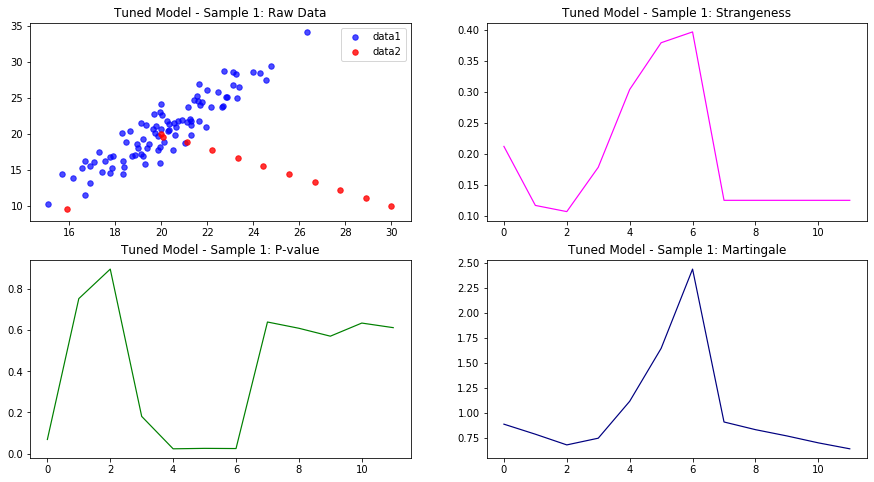

In [24]:
model = KNNAnomalyDetector(n_neighbors = 8, epsilon = 0.85)
perform_experiment(model, cluster1, line1, 'Tuned Model - Sample 1')

### 样本 2: 观测点形成不同的聚集区或者有突变的情况

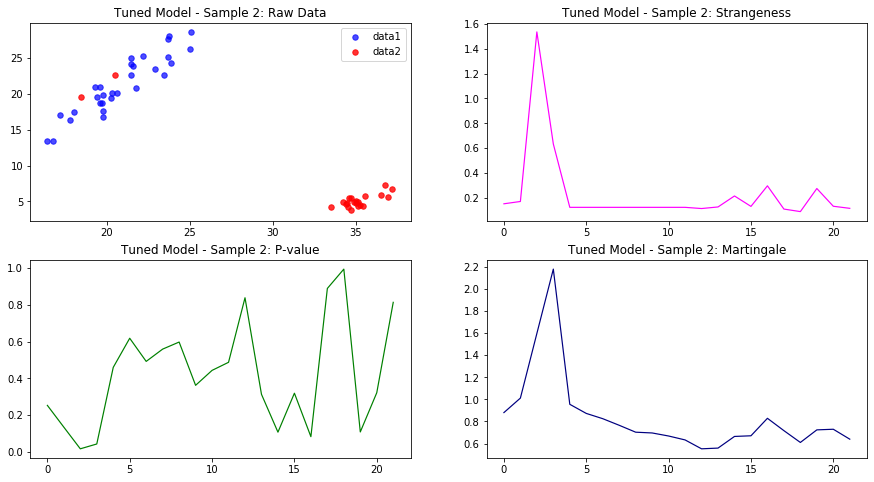

In [25]:
model = KNNAnomalyDetector(n_neighbors = 8, epsilon = 0.85)
perform_experiment(model, cluster2, cluster3, 'Tuned Model - Sample 2')

对于两种异常，侦测效果都不错。

## 不同的距离

### Manhattan Distance

### 样本 1: 观测点缓慢的偏离聚集区域

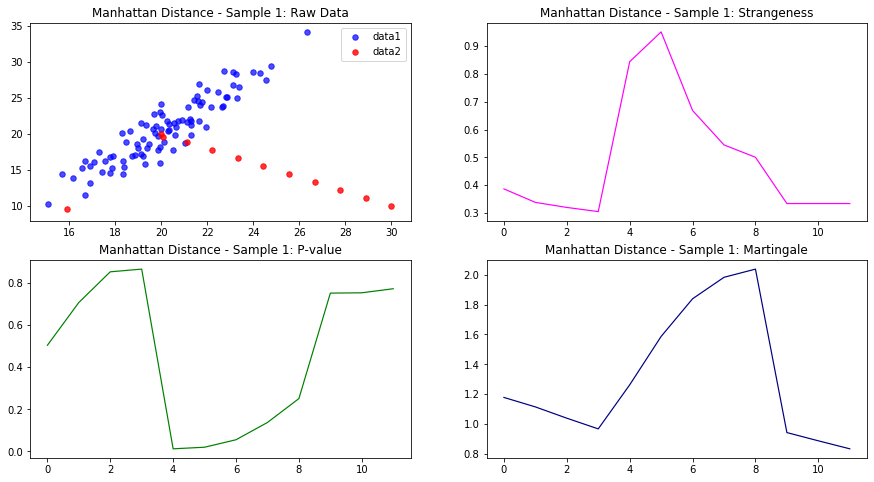

In [26]:
model = KNNAnomalyDetector(metric='manhattan')
perform_experiment(model, cluster1, line1, 'Manhattan Distance - Sample 1')

### 样本 2: 观测点形成不同的聚集区或者有突变的情况

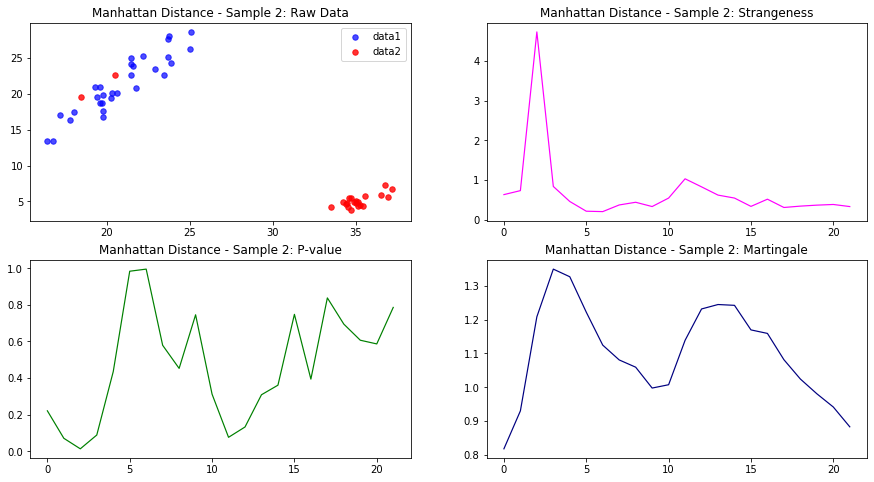

In [27]:
model = KNNAnomalyDetector(metric='manhattan')
perform_experiment(model, cluster2, cluster3, 'Manhattan Distance - Sample 2')

### Chebyshev Distance

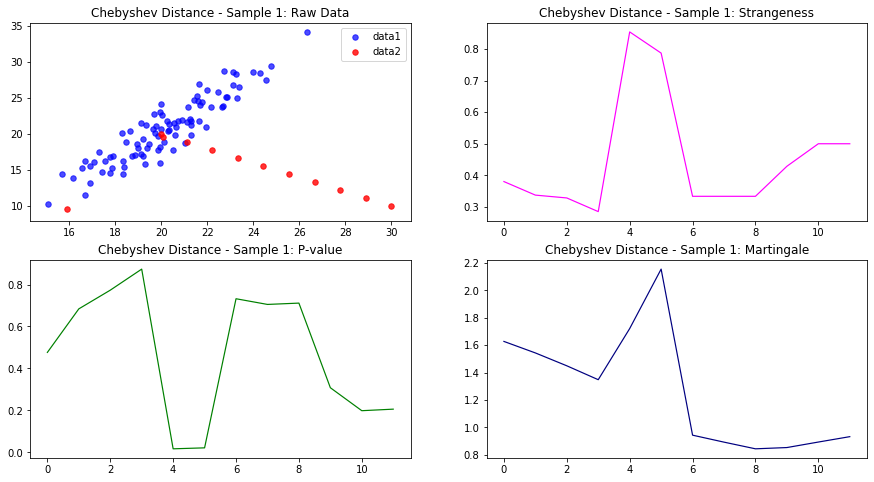

In [28]:
model = KNNAnomalyDetector(metric='chebyshev')
perform_experiment(model, cluster1, line1, 'Chebyshev Distance - Sample 1')

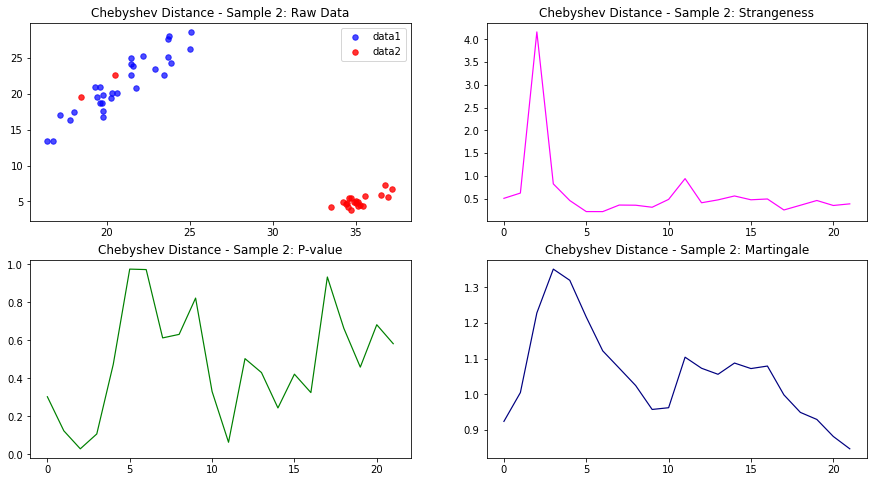

In [29]:
model = KNNAnomalyDetector(metric='chebyshev')
perform_experiment(model, cluster2, cluster3, 'Chebyshev Distance - Sample 2')


在我们的实验中，尚不大清楚那种距离更好以及为什么。但是当我们在高维数据上进行分析的时候，几种距离都试试是比较好的方式。

### Density Versus Proximity

### 样本 1: 观测点缓慢的偏离聚集区域

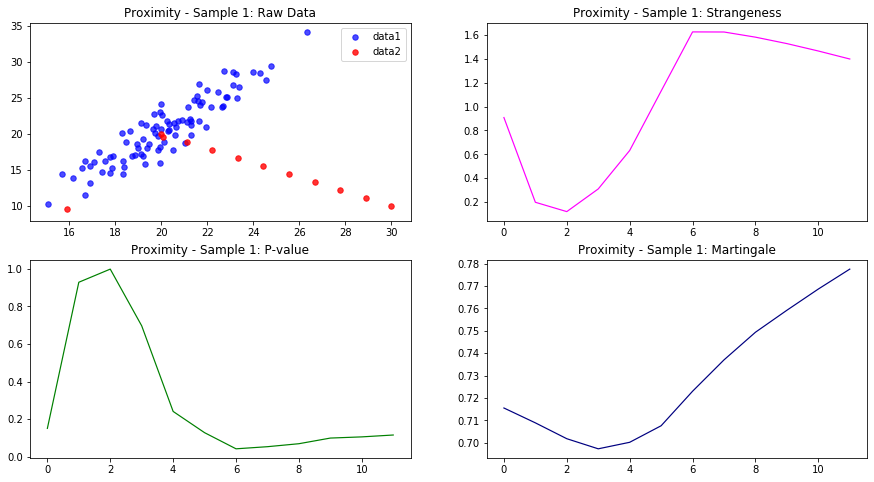

In [30]:
model = KNNAnomalyDetector(method='proximity', epsilon = 0.99)
perform_experiment(model, cluster1, line1, 'Proximity - Sample 1')

### 样本 2: 观测点形成不同的聚集区或者有突变的情况

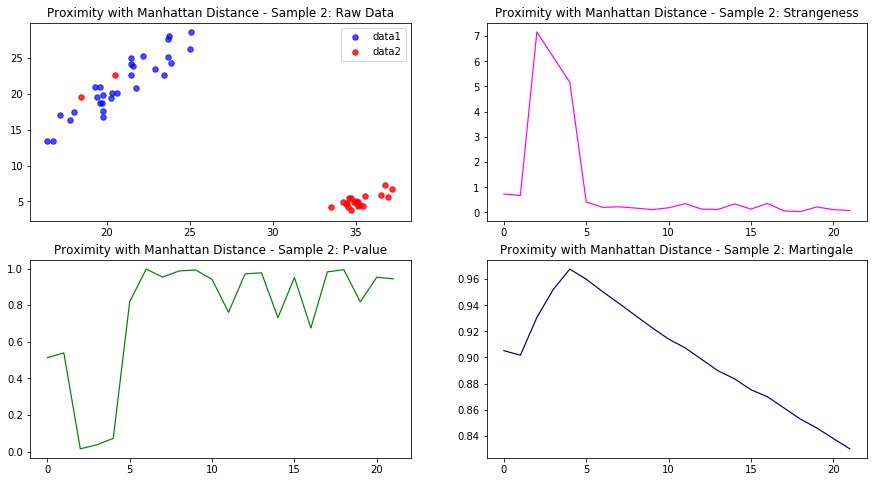

In [31]:
model = KNNAnomalyDetector(method='proximity', metric='manhattan', epsilon = 0.99)
perform_experiment(model, cluster2, cluster3, 'Proximity with Manhattan Distance - Sample 2')


近邻最大距离计量方式似乎相对较弱。请读者自行进行更多实验来探索其使用的适用范围。